# 量子機械学習による画像分類

> このLabは2021年Challenge Fall Lab3 part Ⅰを基に作成しました。

## はじめに

機械学習技術は，近年その高い性能と汎用性の高さから非常に注目を集めています。実際、アルゴリズムの発展や計算資源の増大に伴って様々な産業において実用化が進められています。  
その代表例の一つは画像認識です。機械学習によって人間と同等以上の精度で画像を分類できるようになっています。これにより，例えば衣料画像の自動分類が可能となり，アパレル分野におけるネットショッピングがより便利になりました。

量子計算を機械学習に応用することによって，その性能を更に向上することができる可能性が近年示されています。
このような枠組みを量子機械学習と呼び，量子サポートベクターマシン (QSVM) や量子敵対的生成ネットワーク (QGAN) など，様々なアルゴリズムが提案されています。このチャレンジでは， QSVMを用いて衣料画像の画像分類に取り組みます。

QSVMは，代表的な古典機械学習アルゴリズムの一つであるサポートベクターマシン (SVM) に量子計算を適用したものです。一口にQSVMといっても様々なアプローチが存在し，誤り耐性量子計算を前提として計算の高速化を目指すものや，現在のノイズありデバイスを想定して表現力の向上を目指すものなどがあります。今回のチャレンジは後者に注目したものとなっています。  
今回扱うQSVMの実装では，量子部分をどのように構成するか，具体的には特徴マップ(feature-map)の構成について工夫することが重要です。複雑な特徴マップはより大きな表現力が期待される一方で、ノイズの影響をより受けやすくなるトレードオフが存在するため、そのバランスを考慮して構成を考える必要があります。  
特にノイズを多く含むデバイスを利用する場合に，この点は非常に重要となってきます。

![](./resources/2021-autumn-lab3-ecommerce.jpg)

このLabでは単純なデータセットの二値分類（手書き数字の4と9の分類）を題材として，QSVMの典型的なワークフローを学びます。

In [1]:
!pip install scikit-learn
!pip install qiskit-machine-learning==0.8.2

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Qiskit imports
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_aer import AerSimulator
from qiskit_machine_learning.kernels import FidelityQuantumKernel

## データの準備

ここで扱うデータは MNIST という有名な手書き数字画像データセットの一部（"4"と"9"のみを抽出）です。

このデータセットは，80個のラベル付き訓練データと20個のラベル無しテストデータの，計100個のデータからなります。  
各データは， 28×28 の手書き数字データ画像を配列にしたもので，それぞれの値は 0 (白) から 255 (黒) までの整数となっています。  
このデータセットを QSVM によって分類するためには、まず値を-1から1の間でスケーリングし，次元を量子ビットの数まで圧縮する必要があります。(ここでは5次元としています)

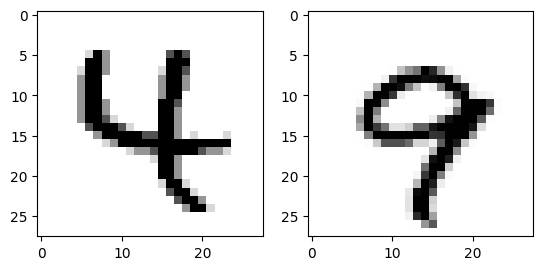

In [3]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part1.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [4, 9]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [4]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_val = ss.transform(sample_val)
sample_test = ss.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_val = mms.transform(sample_val)
sample_test = mms.transform(sample_test)

## データのエンコーディング

今回のタスクである分類を含む、機械学習の一般的な課題はデータのパターンを発見し考察することです。  
実は、多くの機械学習アルゴリズムはデータを線形に分離することを前提としていますが、現実のデータは線形に分離できないことが多いです。  
そのためしばしばデータを高次元空間にマッピングして線形分離するといった手法を採用します。

例えば下図のデータセットを見ると、明らかに2つの円の構造を持っていると分かりますが、これは2次元では線形分離できません。
そこでこのデータをより高次元空間である3次元にマッピング( $\mathbf{z} = (x, y, x^2+y^2)^T$ )してみましょう。  

![](./resources/2022-autumn-lab2-quantum-kernel-mapping.png)

すると図右のように、3次元では超平面で（線形で）分離可能であることがわかります。
このように、データを高次元空間にマッピングすることを「特徴量マッピング」と呼びます。

### 量子特徴量マップ

量子特徴量マップ $\phi(\mathbf{x})$ とはその名の通り，古典データ $\mathbf{x}$ から量子状態 $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$ への写像です。  
これはデータを量子状態という高次元のヒルベルト空間という特徴量空間にマッピングすることを意味します。

Qiskit では以下を始めとする特徴量マップが提供されています。  
これらは [**_Havlicek et al_.  Nature **567**, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2) で紹介されているものです。  
特に `ZZFeatureMap` は古典的にシミュレートすることが難しく、かつ小中規模な量子デバイス上でも実装できると見込まれています。

- `PauliFeatureMap`
- `ZZFeatureMap`
- `ZFeatureMap`

例えば `PauliFeatureMap` のユニタリ演算子は以下のように記述できます。

$$ 
\mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\\ 
U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), 
$$


これは以下のように，エンタングルメントを生成するブロック $U_{\Phi(\mathbf{x})}$ とアダマールゲートのブロックの層が交互に連なった形をしています。
各エンタングルメントブロック $U_{\Phi(\mathbf{x})}$ の中で， $P_i \in \{ I, X, Y, Z \}$ はパウリ行列を表し，添字 $S$ は量子ビット間の接続に対応しています。 ($S \in \{\binom{n}{k}\,\ k = 1,... n \}$)  

<div><img src="./resources/2021-autumn-lab3-featuremap.png" width="1000" /></div>

データのマッピング関数 $\phi_S(\mathbf{x})$ は通常以下で表されます。

$$
\phi_S:\mathbf{x}\mapsto \Bigg\{
\begin{array}{ll}
    x_i                 & if\ S=\{i\} \\
    (\pi-x_i)(\pi-x_j)  & if\ S=\{i,j\}
\end{array}
$$

特に　$k = 1, P_0 = Z$ の場合を `ZFeatureMap` と呼びます。

$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

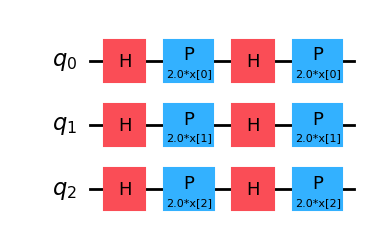

In [5]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

この特徴マップはエンタングルメントを伴わないことから，古典的なシミュレーションが容易であり，量子的な優位性が得られないことに注意してください。

$k = 2, P_0 = Z, P_1 = ZZ$のとき，`ZZFeatureMap`となります。
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

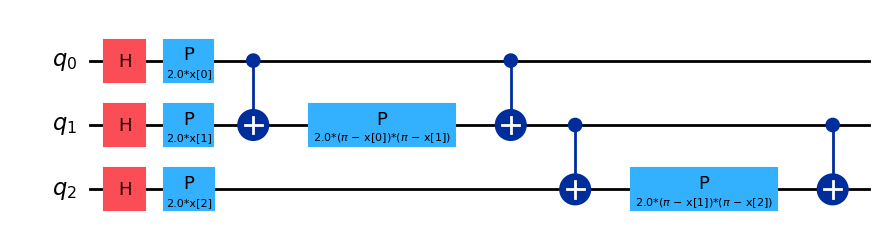

In [6]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

この特徴量マップにはエンタングルメントが含まれており，その形を以下のように変更することができます。

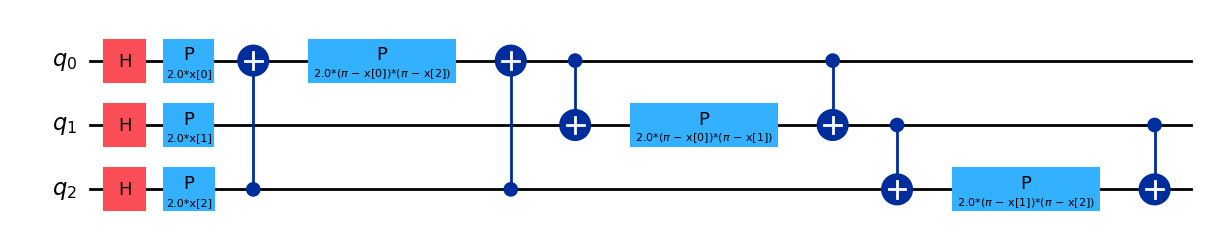

In [7]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

特徴量マップ中のパウリゲートをカスタマイズすることも可能です。例えば $P_0 = X, P_1 = Y, P_2 = ZZ$ とする場合は以下のようになります。

$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

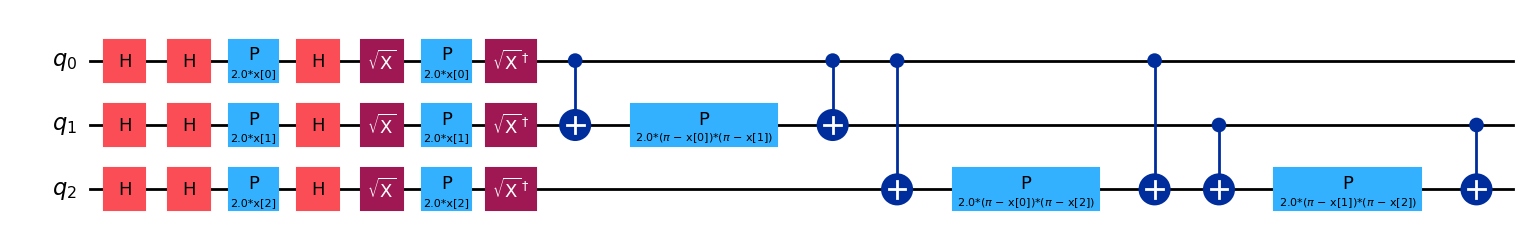

In [8]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

パラメータ付き回路を特徴マップとして用いるためには，`NLocal` と `TwoLocal` を利用することができます。  
どちらも回転ゲートの層とエンタングルメント層を交互に繰り返すパラメータ付き回路を作成します。  
`NLocal` では各ブロックが任意のサイズとできる一方で，`TwoLocal`ではローテーション層は一量子ビットゲート，エンタングルメント層は2量子ビットゲートに限定されます。

例えば以下は `TwoLocal` の回路で，回転層に $R_y$ と $R_Z$ ゲート，エンタングルメント層に $CNOT$ ゲートを用いて，循環的なエンタングルメントを実現しています。

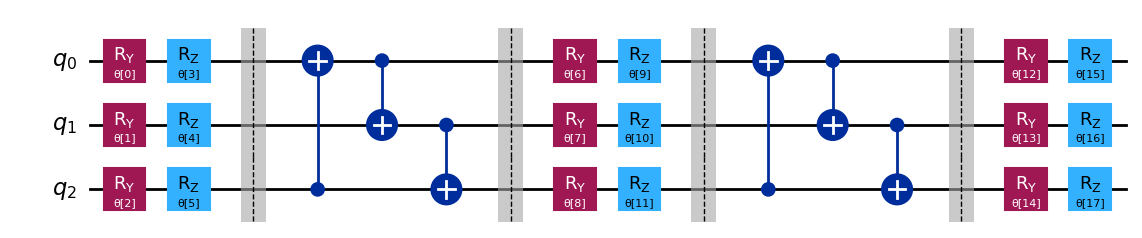

In [9]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

同じものは，`NLocal`で以下のように実現できます。

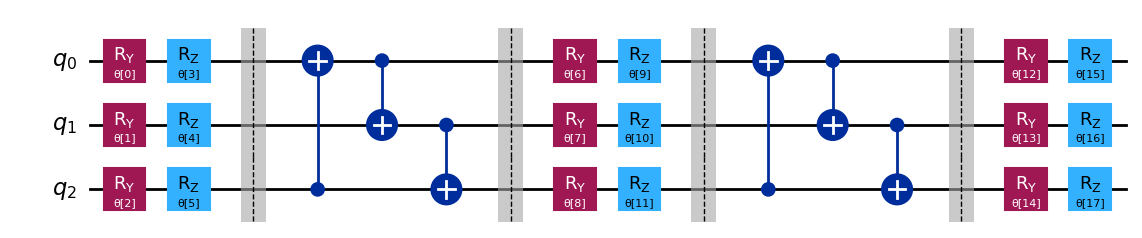

In [10]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

それでは，1個目の訓練データを `PauliFeatureMap`によってエンコードしてみましょう。

In [11]:
print(f'First training data: {sample_train[0]}')

First training data: [-0.4755618  -0.42255764  0.30046422 -0.00534902 -0.89478119]


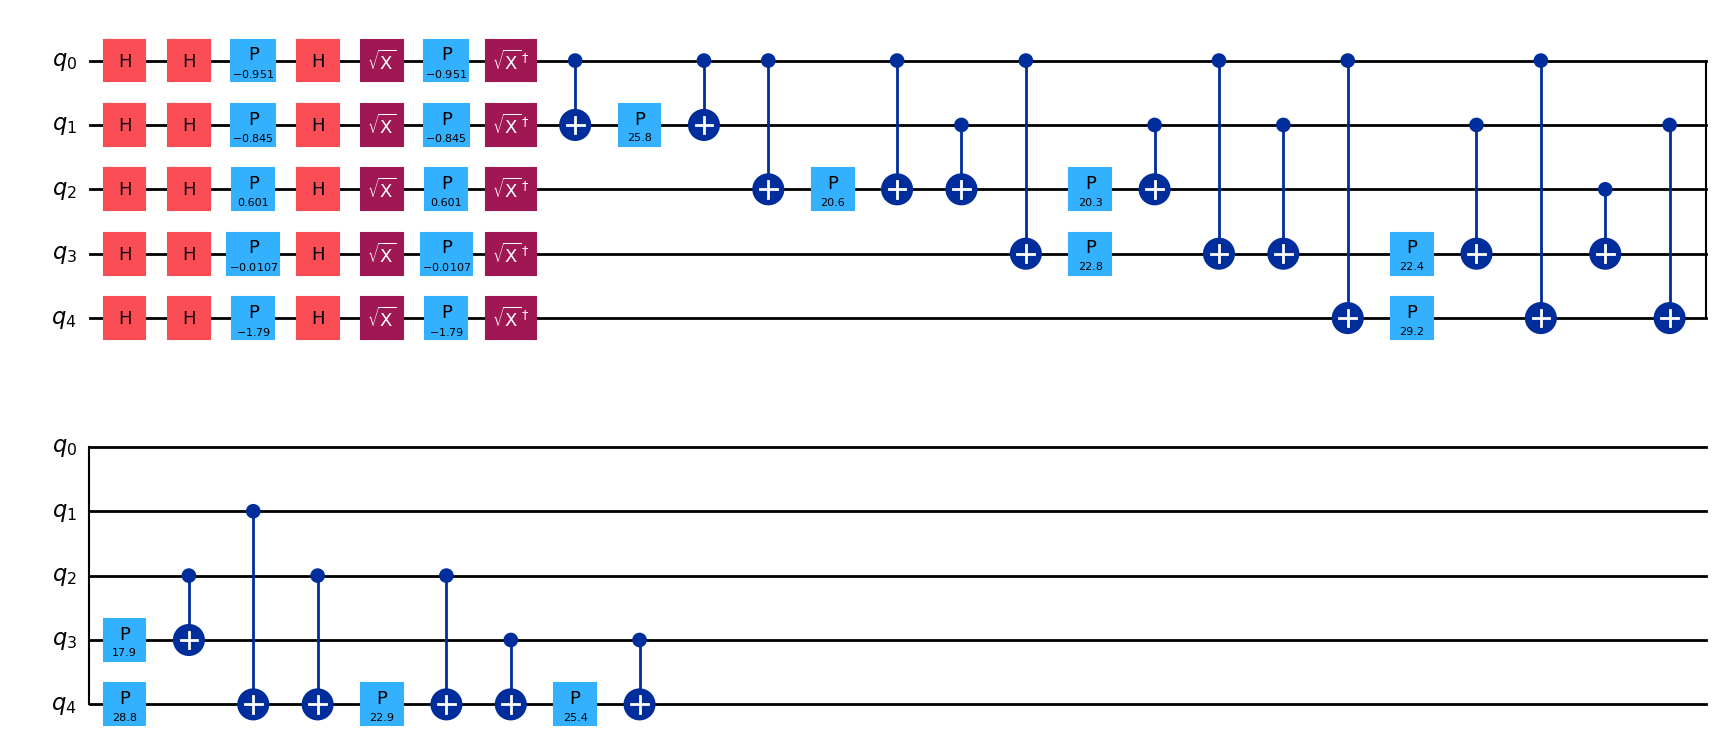

In [12]:
encode_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
encode_circuit = encode_map.assign_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

#### Exercise: `ZZFeatureMap`の実装
````{admonition} Exercise

5次元データをエンコードする特徴量マップを`ZZFeatureMap`によって構成してください。
- 層の繰り返しは3回
- エンタングルメントは'circular'型
- それ以外はデフォルト設定のまま

```python
ex_fmap = ZZFeatureMap(...)
```
````

In [13]:
##############################
# Provide your code here


ex_fmap = ZZFeatureMap(feature_dimension=N_DIM, reps=3, entanglement='circular')

##############################

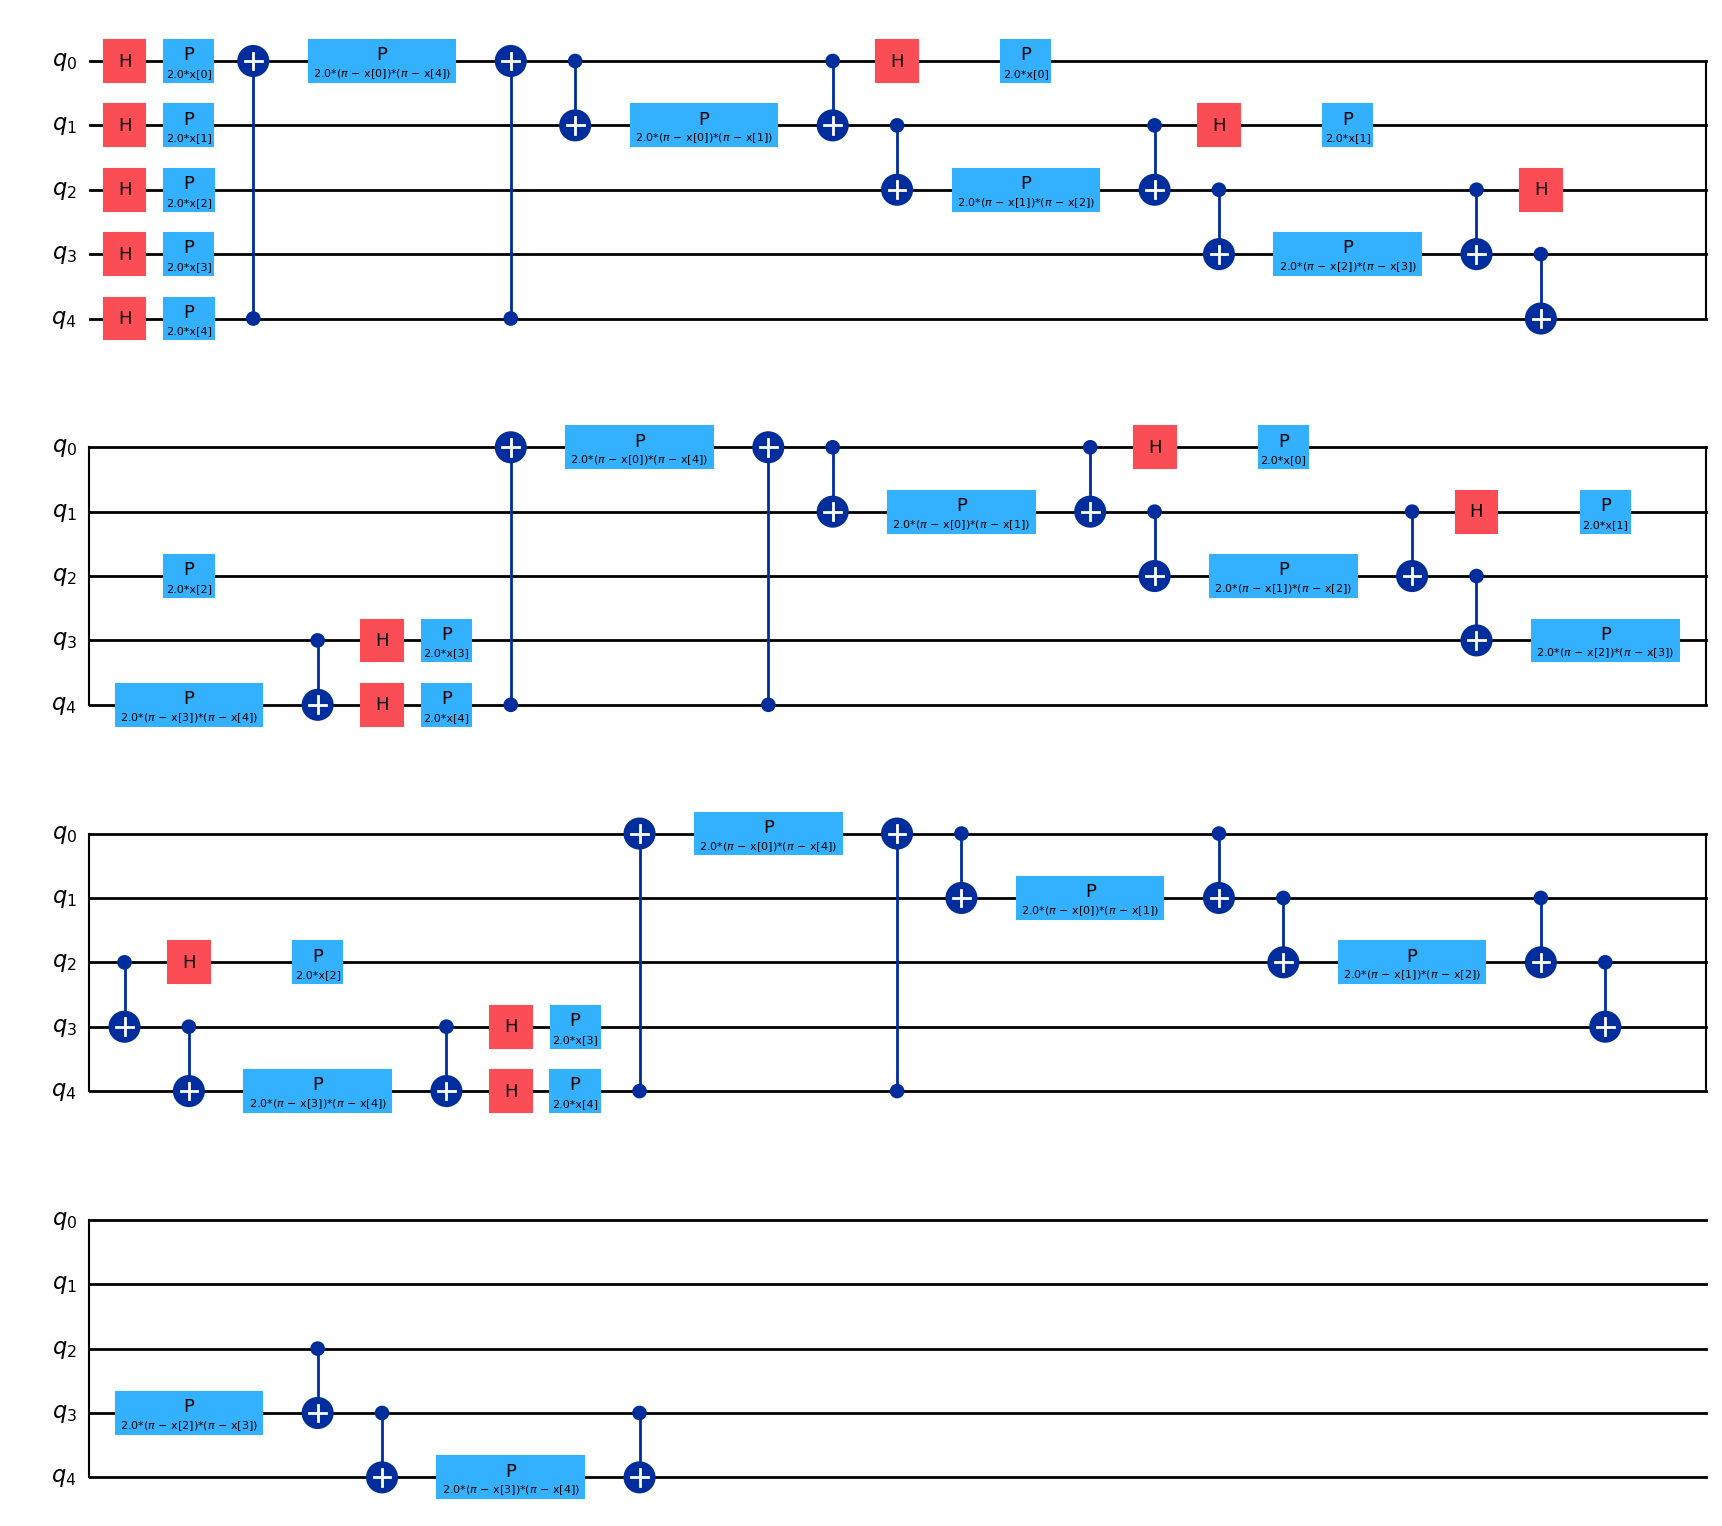

In [14]:
ex_fmap.decompose().draw('mpl')

## 量子カーネル推定

特徴量マッピングは強力な手法ですが、マッピングによる新たな特徴量空間は、元のデータ空間よりも次元が高くなるため、計算コストが増大するという欠点を持っています。  
そこで、古典機械学習ではカーネル法と呼ばれる手法が用いられます。  
カーネル法は、データを高次元空間にマッピングすることなく、高次元空間への写像後の内積を直接計算する手法です。多くの機械学習アルゴリズムでは内積計算の結果さえ取得できれば処理に影響がないため、カーネル法は非常に有用であり、「カーネルトリック」などと呼ばれています。

$$ k(x_i, x_j) = \phi(x_i)^\dagger \phi(x_j) $$

---

量子計算においても同様に、量子特徴量マップ $\phi(\mathbf{x})$ から量子カーネル $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$ を考えることができます。  
量子カーネル法では、古典カーネル法と同様に、入力データを量子状態にエンコードし、その内積の大きさを計算することで、量子カーネルを計算します。
有限次元のデータを考える場合，量子カーネルは全てのデータペアに対して内積を計算することで、行列 $K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$ として表すことができます。  

このカーネル行列の各要素は，物理的には量子状態 $|\phi(\mathbf{x}_i) \rangle$ から $|\phi(\mathbf{x}_j) \rangle$ への遷移確率を表しています。

$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$

ここで特徴量マップは $n$ 量子ビットに対するユニタリー変換 $\mathbf{U_\phi}(\mathbf{x})$ として記述されるパラメータ付き回路を仮定しています。  
これにより量子カーネル行列の推定値を得ることができ、サポートベクターマシンなどのカーネル機械学習アルゴリズムに利用することができます。

[***Havlicek et al*.  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2)で議論されているように，量子カーネルに基づくアルゴリズムは，その量子カーネルを古典的に推定するのが難しい場合にのみ優位性をもつ可能性があります。また古典的に量子カーネルを推定することの難しさは，量子優位性をもつための必要条件に過ぎず，十分条件ではありません。（量子優位性をもつ手法の量子カーネルが必ずしも全て古典的に推定が難しいとは限らない）  
一方で，[***Liu et al.* arXiv:2010.02174 (2020)**](https://arxiv.org/abs/2010.02174)では，全ての古典学習器に対して量子優位性をもつような問題の存在が示されています。

さて、データの前準備ができたら `PauliFeatureMap` を使って `QuantumKernel` クラスを設定し、シミュレータを用いてカーネル行列を推定してみましょう。

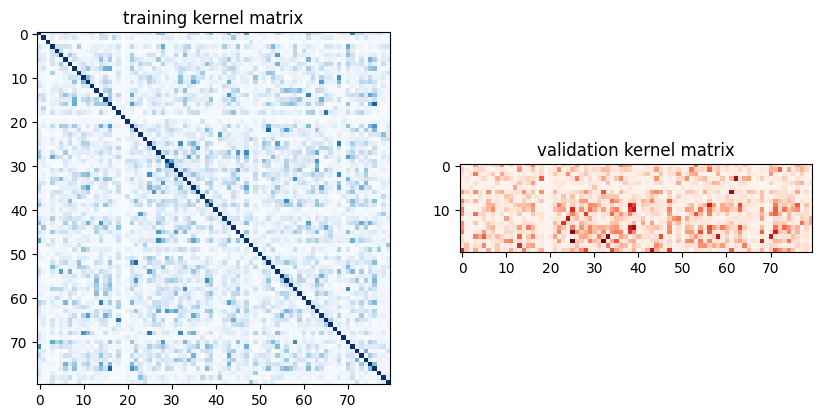

In [15]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = FidelityQuantumKernel(feature_map=pauli_map)

matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_val),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

### Exercise: 量子カーネルの計算
````{admonition} Exercise

$x = (-0.5, -0.4, 0.3, 0, -0.9)$ と $y = (0, -0.7, -0.3, 0, -0.4)$ の間の遷移確率を計算してください。
- 特徴量マップは `ZZFeatureMap` 
    - 層の繰り返しは3回
    - エンタングルメントは'circular'型
    - それ以外はデフォルト設定のまま

```python
x = [-0.5, -0.4, 0.3, 0, -0.9]
y = [0, -0.7, -0.3, 0, -0.4]

##############################
# Provide your code here


ex_amp = 


##############################```
````  

In [16]:
x = [-0.5, -0.4, 0.3, 0, -0.9]
y = [0, -0.7, -0.3, 0, -0.4]

##############################
# Provide your code here

ex_fmap = ZZFeatureMap(feature_dimension=len(x), reps=3, entanglement='circular')
ex_kernel = FidelityQuantumKernel(feature_map=ex_fmap)

ex_amp = ex_kernel.evaluate(x_vec=x, y_vec=y)

print(ex_amp[0][0])


##############################

0.006626981295732


## 量子サポートベクターマシン (QSVM)

[***Havlicek et al*.  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2)で提案された，量子カーネルサポートベクター分類アルゴリズムは，以下のステップから構成されています。

1. 量子カーネル行列を訓練用とテスト用それぞれで構築する。
    1. 訓練データの各ペア　$\mathbf{x}_{i},\mathbf{x}_j$ で，特徴マップを適用し，遷移確率を測定する。 $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $
    2. 訓練データ $\mathbf{x_i} $とテストデータ $\mathbf{y_j}$ の各ペアで，特徴マップを適用し，遷移確率を測定する。$ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $
2. 量子カーネル行列を古典的なサポートベクターマシン分類アルゴリズムで使用する。

以下のコードは，先に計算した訓練用とテスト用のカーネル行列を受け取り，`scikit-learn`の`svc`アルゴリズムに提供しています：

In [17]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Precomputed kernel classification test score: 60.0%
